In [2]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

TODO:
+ add at least one more custom routing example to make parameters clearer
+ Maybe label parameters on custom route plots

# Routing

Often when creating a design, there's the need to connect geometries together with wires or waveguides.  To help with that, PHIDL has a `phidl.routing` (`pr`) module that can flexibly and quickly create paths between ports.  This module is broken into two main components:

- Functions that start with `pr.path_` (e.g. `pr.path_manhattan()`) create `Path`s between ports. These `Path` routes can then be extruded using arbitrary `CrossSection`s
- Functions that start with `pr.route_` (e.g. `pr.route_smooth()`) create the extrusion/polygons immediately for convenience.

## Automatic manhattan routing using `pr.path_manhattan()`



If we want to connect two ports that are orthogonal or parrallel to each other, we can automatically create a path for the route using `pr.path_manhattan`, and smooth it out using `pp.smooth` (e.g. to make a smooth waveguide) :

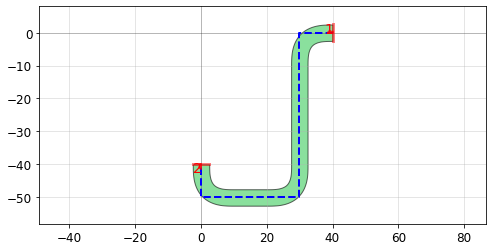

In [79]:
from phidl import Device, CrossSection, quickplot as qp, set_quickplot_options
import phidl.routing as pr
import phidl.path as pp

set_quickplot_options(show_ports=True, show_subports=False)


D = Device()
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

route_path = pr.path_manhattan(port1, port2, radius=10) # radius parameter ensures enough room for bends created by pp.smooth
smoothed_path = pp.smooth(route_path, radius=10, use_eff=True)
X = CrossSection().add(width=5, layer=0)
D.add_ref(smoothed_path.extrude(X))
qp([route_path,D])

## Quick routing with `pr.route_smooth()` and `pr.route_sharp()`

Above we created the route path using `pr.path_manhattan()`, smoothed it using `pp.smooth()`, and extruded it to generate the route polygon. Youc can complete the same steps in just one line of code using the convenience functions `pr.route_smooth()` (e.g. for waveguides) and `pr.route_sharp()` (e.g. for wiring).

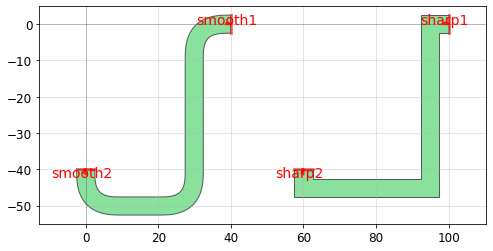

In [70]:
D = Device()
port1 = D.add_port(name='smooth1', midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name='smooth2', midpoint=(0, -40), width=5, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='manhattan'))

port3 = D.add_port(name='sharp1', midpoint=(100,0), width=5, orientation=180)
port4 = D.add_port(name='sharp2', midpoint=(60, -40), width=5, orientation=270)
D.add_ref(pr.route_sharp(port3, port4, path_type='manhattan'))

qp(D)

These convenience functions have parameters that allow near-complete control of the path extrusion:

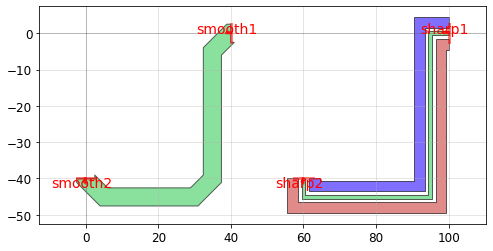

In [71]:
D = Device()
port1 = D.add_port(name='smooth1', midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name='smooth2', midpoint=(0, -40), width=5, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, radius=5, smooth_options={'corner_fun': pp.arc, 'num_pts': 8}))

port3 = D.add_port(name='sharp1', midpoint=(100,0), width=5, orientation=180)
port4 = D.add_port(name='sharp2', midpoint=(60, -40), width=5, orientation=270)
X = CrossSection().add(width=1)
X.add(width=3,offset=3, layer=1)
X.add(width=3, offset=-3, layer=2)
D.add_ref(pr.route_sharp(port3, port4, cross_section=X))

qp(D)

## Customizing routes

Sometimes, automatic routes will run into another device in your layout, like this:

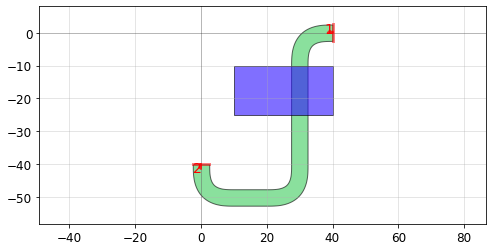

In [43]:
import phidl.geometry as pg

set_quickplot_options(show_ports=True, show_subports=False)

D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='manhattan'))
qp(D)

To fix this overlap, we need to create a route along a custom path. PHIDL provides several `pr.path_***` functions to help you create different types of paths to route along. All the path types are described below, but in this case, we want a `J`-path. We can force `route_smooth` to use `path_J()` via the parameter `path_type='J'`.

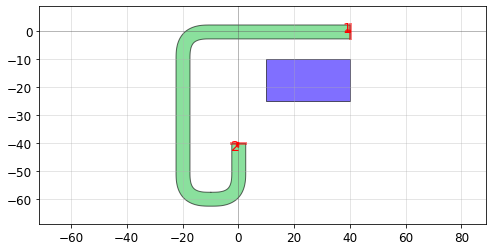

In [69]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='J', length1=60, length2=20))
qp(D)


For ease of use, the `pr.path_***` functions are parameterized in terms of relative distances from ports. Above, we set `length1` and `length2`, which define the lengths of the line segments that exit `port1` and `port2` respectively (i.e. the first and last sements in the path). Once those first and last segments are set, `path_J()` then completes the `Path` by connecting the segments with two more segments at right angles. 

## Routing path types

PHIDL provides the following path types for routing. 

| Path type | Routing style| Segments | Useful for ... | Parameters |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| `straight`  | Manhattan   | 1           | ports that point directly at each other.| -- |
| `L`         | Manhattan   | 2           | orthogonal ports that can be connected with one turn.| -- |
| `U`         | Manhattan   | 3           | parrallel ports that face each other or same direction.| `length1` |
| `J`         | Manhattan   | 4           | orthogonal ports that can't be connected with just one turn.| `length1`, `length2` |
| `C`         | Manhattan   | 5           | parrallel ports that face apart.| `length1`, `length2`, `left1` |
| `manhattan` | Manhattan   | 1-5         | parrallel or orthogonal ports.| `radius` |
| `V`         | Free        | 2           | ports at odd angles that face a common intersection point.| -- |
| `Z`         | Free        | 3           | ports at odd angles.| `length1`, `length2` |

Most path types are named after letters that they resemble to help you remember them. However, as you'll see in the examples below, some of the more complicated paths can take a variety of shapes. One good way to identify which Manhattan route type you need is to count the number of line segments and consult the above table.



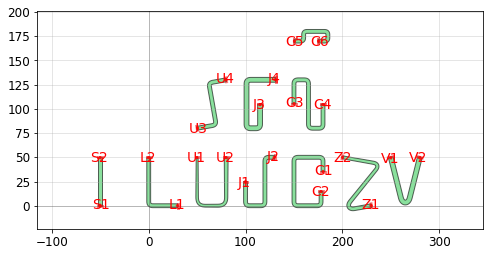

In [82]:
D = Device()

#straight path
port1 = D.add_port(name='S1', midpoint=(-50, 0), width=4, orientation=90)
port2 = D.add_port(name='S2', midpoint=(-50, 50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='straight'))
#L path
port1 = D.add_port(name='L1', midpoint=(30,0), width=4, orientation=180)
port2 = D.add_port(name='L2', midpoint=(0, 50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2,  path_type='L'))
#U path
port1 = D.add_port(name='U1', midpoint=(50, 50), width=2, orientation=270)
port2 = D.add_port(name='U2', midpoint=(80,50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2,  radius=10, path_type='U', length1=50))
port1 = D.add_port(name='U3', midpoint=(50, 80), width=4, orientation=10)
port2 = D.add_port(name='U4', midpoint=(80, 130), width=4, orientation=190)
D.add_ref(pr.route_smooth(port1, port2,  path_type='U', length1=20))
#J path
port1 = D.add_port(name='J1', midpoint=(100, 25), width=4, orientation=270)
port2 = D.add_port(name='J2', midpoint=(130, 50), width=4,  orientation=180)
D.add_ref(pr.route_smooth(port1, port2,  path_type='J', length1=25, length2=10))
port1 = D.add_port(name='J3', midpoint=(115, 105), width=5, orientation=270)
port2 = D.add_port(name='J4', midpoint=(131, 130), width=5,  orientation=180)
D.add_ref(pr.route_smooth(port1, port2, path_type='J', length1=25, length2=30))
#C path
port1 = D.add_port(name='C1', midpoint=(180, 35), width=4, orientation=90)
port2 = D.add_port(name='C2', midpoint=(178, 15), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=15, left1=30, length2=15))
port1 = D.add_port(name='C3', midpoint=(150, 105), width=4, orientation=90)
port2 = D.add_port(name='C4', midpoint=(180, 105), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=25, left1=-15, length2=25))
port1 = D.add_port(name='C5', midpoint=(150, 170), width=4, orientation=0)
port2 = D.add_port(name='C6', midpoint=(175, 170), width=4, orientation=0)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=10, left1=10, length2=10, radius=4))
#Z path
port1 = D.add_port(name='Z1', midpoint=(230,0), width=4, orientation=190)
port2 = D.add_port(name='Z2', midpoint=(200, 50), width=3, orientation=-10)
D.add_ref(pr.route_smooth(port1, port2, path_type='Z', length1=30, length2=40))
#V path
port1 = D.add_port(name='V1', midpoint=(250,50), width=5, orientation=284)
port2 = D.add_port(name='V2', midpoint=(280, 50), width=5, orientation=270-14)
D.add_ref(pr.route_smooth(port1, port2, path_type='V'))

qp(D)

The `manhattan` path type is bending-radius aware and can produce any route neccessary to connect two ports, as long as they are orthogonal or parrallel. 

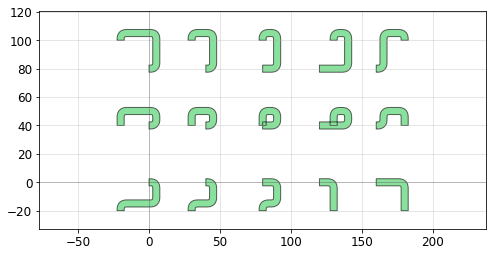

In [91]:
import numpy as np

set_quickplot_options(show_ports=False, show_subports=False)

D = Device() 
pitch = 40
test_range=20
xdevs = np.arange(5)*pitch
ydevs = np.arange(3)*pitch
xtest = np.linspace(-1*test_range, test_range, 5)
ytest = np.linspace(-1*test_range, test_range, 3)
for xidx, xdev in enumerate(xdevs):
    for yidx, ydev in enumerate(ydevs):
        devname = '{}{}'.format(xidx, yidx)
        port1 = D.add_port(name=devname+'1', midpoint=(xdev, ydev), width=5, orientation=0)
        port2 = D.add_port(name=devname+'2', midpoint=(xdev+xtest[xidx], ydev+ytest[yidx]), 
                           width=5,  orientation=90)
        D.add_ref(pr.route_smooth(port1, port2, route_type='manhattan'))
qp(D)